In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
drivers_df = pd.read_pickle('../output/real_dist_drivers.pkl')
riders_df = pd.read_pickle('../output/real_dist_riders.pkl')

# max_drivers_df = pd.read_pickle('../output/max_drivers.pkl')
# max_riders_df = pd.read_pickle('../output/max_riders.pkl')

# re_pa_drivers_df = pd.read_pickle('../output/re_pa_drivers.pkl')
# re_pa_riders_df = pd.read_pickle('../output/re_pa_riders.pkl')

# real_drivers_df = pd.read_pickle('../output/real_dist_drivers.pkl')
# real_riders_df = pd.read_pickle('../output/real_dist_riders.pkl')

# fast_drivers_df = pd.read_pickle('../output/fast_drivers.pkl')
# fast_riders_df = pd.read_pickle('../output/fast_riders.pkl')

# in_ri_drivers_df = pd.read_pickle('../output/in_ri_drivers.pkl')
# in_ri_riders_df = pd.read_pickle('../output/in_ri_riders.pkl')

# cor_drivers_df = pd.read_pickle('../output/cor_drivers.pkl')
# cor_riders_df = pd.read_pickle('../output/cor_riders.pkl')

# wait_drivers_df = pd.read_pickle('../output/wait_drivers.pkl')
# wait_riders_df = pd.read_pickle('../output/wait_riders.pkl')

improved_drivers_df = pd.read_pickle('../output/es_improved_drivers.pkl')
improved_riders_df = pd.read_pickle('../output/es_improved_riders.pkl')

# im_drivers_df = pd.read_pickle('../output/given_improvements_drivers.pkl')
# im_riders_df = pd.read_pickle('../output/given_improvements_riders.pkl')


# im_drivers_df = pd.read_pickle('../output/waiting_points_drivers.pkl')
# im_riders_df = pd.read_pickle('../output/waiting_points_riders.pkl')

# br_drivers_df = pd.read_pickle('../output/drivers_break_drivers.pkl')
# br_riders_df = pd.read_pickle('../output/drivers_break_riders.pkl')

# ps_drivers_df = pd.read_pickle('../output/pre_search_drivers.pkl')
# ps_riders_df = pd.read_pickle('../output/pre_search_riders.pkl')

# ff_drivers_df = pd.read_pickle('../output/improved_drivers.pkl')
# ff_riders_df = pd.read_pickle('../output/improved_riders.pkl')

In [4]:
concurrent_df = pd.read_csv('../output/given_improvements_concurrent_data.csv')
in_dr_concurrent_df = pd.read_csv('../output/in_dr_concurrent_data.csv')
re_pa_concurrent_df = pd.read_csv('../output/re_pa_concurrent_data.csv')
real_concurrent_df = pd.read_csv('../output/real_dist_concurrent_data.csv')
fast_concurrent_df = pd.read_csv('../output/fast_concurrent_data.csv')
in_ri_concurrent_df = pd.read_csv('../output/in_ri_concurrent_data.csv')
# im_concurrent_df = pd.read_csv('../output/given_improvements_concurrent_data.csv') 

In [5]:
def abandon_overtime(riders_df):
    temp_df = riders_df.copy()

    # Remove 'waiting' and 'riding' statuses
    temp_df = temp_df[~temp_df['status'].isin(['waiting', 'riding'])]
    temp_df['time'] = temp_df['become_available']

    custom_palette = {
        'matched': '#4CAF50',  # Vibrant Green
        'abandoned': '#FF5252',  # Bright Red
    }

    # Define equal-sized time intervals
    time_min, time_max = temp_df['time'].min(), temp_df['time'].max()
    # Adjust bin width as needed; here 5000 is used as the bin width
    bin_edges = list(range(int(time_min), int(time_max) + 6, 5000))
    interval_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    temp_df['time_interval'] = pd.cut(temp_df['time'], bins=bin_edges, 
                                      labels=interval_labels, include_lowest=True)

    # Combine 'reached_destination' and 'transit' into 'matched'
    temp_df['status'] = temp_df['status'].replace({'reached_destination': 'matched', 'transit': 'matched'})

    # Calculate counts per status in each time interval
    status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)
    total_counts = status_counts.sum(axis=1)
    status_rates = status_counts.div(total_counts, axis=0)

    # Calculate standard error for each rate
    status_se = status_rates.copy()
    for idx in status_rates.index:
        n = total_counts.loc[idx]
        for col in status_rates.columns:
            p = status_rates.loc[idx, col]
            # Avoid division by zero if no data is present in a time interval
            status_se.loc[idx, col] = np.sqrt(p * (1 - p) / n) if n > 0 else 0

    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Create the line plot for rates
    plt.figure(figsize=(8, 5))
    ax = sns.lineplot(data=status_rates, markers=True, palette=custom_palette)
    
    # Overlay error bars using the computed standard errors
    # Use numeric x positions for the categorical intervals
    x_positions = np.arange(len(status_rates.index))
    for status in status_rates.columns:
        y_values = status_rates[status].values
        y_err = status_se[status].values
        ax.errorbar(x=x_positions, y=y_values, yerr=y_err, fmt='none',
                    color=custom_palette[status], capsize=5)

    # Set x tick labels to the original time_interval labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(status_rates.index, rotation=90, color='darkgray')
    
    # Labels and title
    ax.set_xlabel("Time Interval", color='darkgray')
    ax.set_ylabel("Rate", color='darkgray')
    ax.set_title("Rate of Each Status Over Time Intervals", color='darkgray')
    ax.tick_params(axis='y', colors='darkgray')
    
    plt.show()

In [6]:
def riders_analysis(riders_df):
    """
    Perform overall analysis of the riders data and generate multiple distribution plots.
    
    This analysis includes:
      - Distribution of rider statuses.
      - Distributions of waiting time, wait-till-match time, and pickup-wait time.
      - Comparison of trip-related metrics.
    
    Returns:
      - The original riders_df.
      - A filtered DataFrame of riders who reached their destination with computed metrics.
    """
    # For status counts, we can use a countplot that mimics a distribution style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 5))
    # Using countplot which fits well with discrete data
    custom_palette = {
        'reached_destination': '#4CAF50',  # Vibrant Green
        'abandoned': '#FF5252',            # Bright Red
        'riding': '#42A5F5', 
        'matched': '#42A5F5',              # Vivid Blue
        'waiting': '#FFA726'               # Bright Orange
    }
    ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')
    for container in ax.containers:
        ax.bar_label(container)
    plt.xlabel("Status", color='black')
    plt.ylabel("Count", color='black')
    plt.title("Distribution of Rider Statuses", color='black')
    plt.xticks(rotation=15, color='black')
    plt.tight_layout()
    plt.show()
    
    # Filter riders who reached destination and compute time metrics
    filtered_riders_df = riders_df.loc[riders_df['status'] == 'reached_destination'].copy()
    filtered_riders_df.loc[:, 'total_system_time'] = (
        filtered_riders_df['destination_time'] - filtered_riders_df['become_available']
    )
    filtered_riders_df.loc[:, 'total_trip_time'] = (
        filtered_riders_df['destination_time'] - filtered_riders_df['pick_up_time']
    )
    filtered_riders_df.loc[:, 'waiting_time'] = (
        filtered_riders_df['pick_up_time'] - filtered_riders_df['become_available']
    )
    filtered_riders_df.loc[:, 'pick_up_wait_time'] = (
        filtered_riders_df['waiting_time'] - filtered_riders_df['wait_till_match']
    )
    
    # Distribution plots for rider time metrics using sns.histplot (matching driver style)
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_riders_df['waiting_time'], bins=30, kde=True, color='#81C784')
    plt.title("Distribution of Waiting Time")
    plt.xlabel("Waiting Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_riders_df['wait_till_match'], bins=30, kde=True, color='#FF7043')
    plt.title("Distribution of Wait Till Match Time")
    plt.xlabel("Wait Till Match Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_riders_df['pick_up_wait_time'], bins=30, kde=True, color='#42A5F5')
    plt.title("Distribution of Pick Up Wait Time")
    plt.xlabel("Pick Up Wait Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # For trip metrics, we can show a boxplot of the average times
    avg_patience_time = filtered_riders_df['patience_time'].mean()
    avg_wait_till_match_time = filtered_riders_df['wait_till_match'].mean()
    avg_pick_up_wait_time = filtered_riders_df['pick_up_wait_time'].mean()
    avg_trip_time = filtered_riders_df['total_trip_time'].mean()
    avg_waiting_time = filtered_riders_df['waiting_time'].mean()
    
    metrics = ['Mean Patience Time', 'Mean Wait Till Match Time', 'Mean Pick Up Time', 'Mean Trip Time']
    values = [avg_patience_time, avg_wait_till_match_time, avg_pick_up_wait_time, avg_trip_time]
    # Using a bar plot for average metrics, styled similarly
    plt.figure(figsize=(8, 6))
    sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])
    plt.xlabel("Metrics")
    plt.ylabel("Time (Minutes)")
    plt.title("Average Rider Trip Times")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    n_abandon = riders_df[riders_df['status'] == 'abandoned']['id'].count();
    total_riders = riders_df.shape[0]
    print('############# Rider statisfaction #######################')
    p = n_abandon / total_riders
    se = np.sqrt(p * (1 - p) / total_riders)
    print(f'The system abandonment rate is {p:.3f} with a standard error of {se:.3f}')
    abandon_overtime(riders_df)
    print('### wait Time ###')

    # Average waiting time and its SE
    avg_waiting_time = filtered_riders_df['waiting_time'].mean()
    se_waiting_time = filtered_riders_df['waiting_time'].std() / np.sqrt(len(filtered_riders_df['waiting_time']))
    print(f"The system average riders wait time {avg_waiting_time:.3f} with SE {se_waiting_time:.3f}")
    
    print("### wait for match ###")
    # Wait until match time and its SE
    avg_wait_till_match = filtered_riders_df['wait_till_match'].mean()
    se_wait_till_match = filtered_riders_df['wait_till_match'].std() / np.sqrt(len(filtered_riders_df['wait_till_match']))
    print(f"The system wait until match time {avg_wait_till_match:.3f} with SE {se_wait_till_match:.3f}")
    
    print("### wait for pick up ###")
    # Pick up wait time and its SE
    avg_pick_up_wait_time = filtered_riders_df['pick_up_wait_time'].mean()
    se_pick_up_wait_time = filtered_riders_df['pick_up_wait_time'].std() / np.sqrt(len(filtered_riders_df['pick_up_wait_time']))
    print(f"The system wait for pick up time {avg_pick_up_wait_time:.3f} with SE {se_pick_up_wait_time:.3f}")


    
    return riders_df, filtered_riders_df


In [7]:
def drivers_analysis(drivers_df):
    """
    Perform overall analysis of driver data for offline drivers.
    
    This analysis includes:
      - Calculation of per-hour earnings, fuel cost, and profit with standard errors.
      - Breakdown of distances (pickup, dropoff, idling, total driving distance).
      - Earnings composition (per hour) with distribution plots.
      - Time breakdown for drivers, plotting pick up time, dropoff time, and idling time together,
        and printing out the average and standard error for each time component.
      - A bar graph of average drivers' metrics (per hour).
      - Printing of key average values along with their SE.
      - Calculation of the GINI coefficient for earnings per hour.
    
    Returns:
      - The original drivers_df.
      - A filtered DataFrame of offline drivers with computed metrics.
    """
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Filter offline drivers
    filtered_drivers_df = drivers_df.loc[drivers_df['status'] == 'offline'].copy()
    
    # Compute total jobs time (assumed in hours; if in another unit, adjust conversion accordingly)
    filtered_drivers_df.loc[:, 'total_jobs_time'] = (
        filtered_drivers_df['actual_offline_time'] - filtered_drivers_df['become_available']
    )
    
    # Compute per-hour earnings
    filtered_drivers_df.loc[:, 'avg_earning_per_hour'] = (
        filtered_drivers_df['earnings'] / filtered_drivers_df['total_jobs_time']
    )
    
    # Compute per-hour fuel cost and profit if available
    if 'fuel_cost' in filtered_drivers_df.columns:
        filtered_drivers_df.loc[:, 'fuel_cost_per_hour'] = (
            filtered_drivers_df['fuel_cost'] / filtered_drivers_df['total_jobs_time']
        )
        # Compute profit and profit per hour
        filtered_drivers_df.loc[:, 'profit'] = (
            filtered_drivers_df['earnings'] - filtered_drivers_df['fuel_cost']
        )
        filtered_drivers_df.loc[:, 'profit_per_hour'] = (
            filtered_drivers_df['profit'] / filtered_drivers_df['total_jobs_time']
        )
    
    # Compute resting time (non-driving) if total driving time is provided.
    if 'total_driving_time' in filtered_drivers_df.columns:
        filtered_drivers_df.loc[:, 'resting_time'] = (
            filtered_drivers_df['total_jobs_time'] - filtered_drivers_df['total_driving_time']
        )
    
    # --- Print Summary Statistics (Per Hour) with SE ---
    n = len(filtered_drivers_df)
    print("----- Driver Earnings Analysis (Per Hour) -----")
    mean_earning = filtered_drivers_df['avg_earning_per_hour'].mean()
    se_earning = filtered_drivers_df['avg_earning_per_hour'].std() / np.sqrt(n)
    print(f"Average Earning per Hour: {mean_earning:.3f} with SE: {se_earning:.3f}")
    
    if 'fuel_cost_per_hour' in filtered_drivers_df.columns:
        mean_fuel = filtered_drivers_df['fuel_cost_per_hour'].mean()
        se_fuel = filtered_drivers_df['fuel_cost_per_hour'].std() / np.sqrt(n)
        print(f"Average Fuel Cost per Hour: {mean_fuel:.3f} with SE: {se_fuel:.3f}")
    
    if 'profit_per_hour' in filtered_drivers_df.columns:
        mean_profit = filtered_drivers_df['profit_per_hour'].mean()
        se_profit = filtered_drivers_df['profit_per_hour'].std() / np.sqrt(n)
        print(f"Average Profit per Hour: {mean_profit:.3f} with SE: {se_profit:.3f}")
    
    # --- GINI Coefficient Calculation for Earnings per Hour ---
    def gini_coefficient(x):
        # Ensure x is a numpy array
        x = np.asarray(x)
        if np.amin(x) < 0:
            x -= np.amin(x)  # values cannot be negative
        x_sorted = np.sort(x)
        n = len(x)
        index = np.arange(1, n + 1)
        return (2 * np.sum(index * x_sorted)) / (n * np.sum(x_sorted)) - (n + 1) / n
    
    gini_earning = gini_coefficient(filtered_drivers_df['avg_earning_per_hour'].values)
    print(f"Gini Coefficient for Earnings per Hour: {gini_earning:.3f}")
    print(f"SD Earnings per Hour: {filtered_drivers_df['avg_earning_per_hour'].std():.5f}")
    
    # --- Distribution Plots (Per Hour Metrics) ---
    # Distribution of Average Earnings per Hour
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_drivers_df['avg_earning_per_hour'], bins=30, kde=True, color='#42A5F5')
    plt.title("Distribution of Average Earnings per Hour")
    plt.xlabel("Average Earnings per Hour")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Distribution of Fuel Cost per Hour (if available)
    if 'fuel_cost_per_hour' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['fuel_cost_per_hour'], bins=30, kde=True, color='#FFCC80')
        plt.title("Distribution of Fuel Cost per Hour")
        plt.xlabel("Fuel Cost per Hour")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # Distribution of Profit per Hour (if computed)
    if 'profit_per_hour' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['profit_per_hour'], bins=30, kde=True, color='#66BB6A')
        plt.title("Distribution of Profit per Hour")
        plt.xlabel("Profit per Hour")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # Earnings Composition Breakdown (Per Hour)
    if {'avg_earning_per_hour', 'fuel_cost_per_hour', 'profit_per_hour'}.issubset(filtered_drivers_df.columns):
        melt_earnings = filtered_drivers_df.melt(
            value_vars=['avg_earning_per_hour', 'fuel_cost_per_hour', 'profit_per_hour'],
            var_name='Earnings Component (per Hour)', value_name='Amount'
        )
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Earnings Component (per Hour)', y='Amount', data=melt_earnings, palette='Set2')
        plt.title("Earnings Breakdown (Per Hour): Earnings, Fuel Cost, and Profit")
        plt.xlabel("Component")
        plt.ylabel("Amount")
        plt.tight_layout()
        plt.show()
    
    # --- Time Breakdown ---
    # First, compute total idling time if not directly available.
    if {'total_time', 'total_pickup_time', 'total_dropoff_time'}.issubset(filtered_drivers_df.columns):
        filtered_drivers_df.loc[:, 'total_idling_time'] = (
            filtered_drivers_df['total_time'] - filtered_drivers_df['total_pickup_time'] - filtered_drivers_df['total_dropoff_time']
        )
    
    time_cols = []
    if 'total_pickup_time' in filtered_drivers_df.columns:
        time_cols.append('total_pickup_time')
    if 'total_dropoff_time' in filtered_drivers_df.columns:
        time_cols.append('total_dropoff_time')
    if 'total_waiting_point_travel_time' in filtered_drivers_df.columns:
        time_cols.append('total_waiting_point_travel_time')
        if 'total_idling_time' in filtered_drivers_df.columns:
            filtered_drivers_df.loc[:, 'total_idling_time'] = filtered_drivers_df['total_idling_time'] - filtered_drivers_df['total_waiting_point_travel_time']
    if 'total_idling_time' in filtered_drivers_df.columns:
        time_cols.append('total_idling_time')
    
    print("Time columns for breakdown:", time_cols)
    
    # --- Print Time Breakdown Averages with SE ---
    if time_cols:
        for col in time_cols:
            avg_time = filtered_drivers_df[col].mean()
            se_time = filtered_drivers_df[col].std() / np.sqrt(len(filtered_drivers_df[col]))
            print(f"Average {col}: {avg_time:.3f} with SE: {se_time:.3f}")
    
    # Plot boxplot for time breakdown
    if time_cols:
        plt.figure(figsize=(8, 5))
        melt_time = filtered_drivers_df.melt(value_vars=time_cols, var_name='Time Category', value_name='Time')
        # Replace underscores with spaces in the 'Time Category' labels
        melt_time['Time Category'] = melt_time['Time Category'].str.replace('_', ' ')
        sns.boxplot(x='Time Category', y='Time', data=melt_time, palette='Set3')
        plt.title("Drivers Time Breakdown: Pick Up, Dropoff, and Idling Times")
        plt.xlabel("Time Category")
        plt.ylabel("Time")
        plt.tight_layout()
        plt.show()
    
    # Plot distribution of Resting Time if computed
    if 'resting_time' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['resting_time'], bins=30, kde=True, color='#81C784')
        plt.title("Distribution of Resting Time")
        plt.xlabel("Resting Time")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # --- Distance Breakdown ---
    if {'total_pickup_distance', 'total_dropoff_distance', 'total_idling_distance'}.issubset(filtered_drivers_df.columns):
        plt.figure(figsize=(8, 5))
        distance_cols = ['total_pickup_distance', 'total_dropoff_distance', 'total_idling_distance']
        melt_distance = filtered_drivers_df.melt(value_vars=distance_cols, var_name='Distance Category', value_name='Distance')
        # Replace underscores with spaces in the 'Distance Category' labels
        melt_distance['Distance Category'] = melt_distance['Distance Category'].str.replace('_', ' ')
        sns.boxplot(x='Distance Category', y='Distance', data=melt_distance, palette='Set2')
        plt.title("Distance Breakdown: Pickup, Dropoff, and Idling Distances")
        plt.xlabel("Distance Category")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()
    
    if 'total_distance' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['total_distance'], bins=30, kde=True, color='#90CAF9')
        plt.title("Distribution of Total Driving Distance")
        plt.xlabel("Total Driving Distance")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # --- Bar Graph of Averages (Per Hour) ---
    metrics = []
    values = []
    if 'avg_earning_per_hour' in filtered_drivers_df.columns:
        avg_earning = filtered_drivers_df['avg_earning_per_hour'].mean()
        metrics.append("Avg Earning per Hour")
        values.append(avg_earning)
    
    if 'profit_per_hour' in filtered_drivers_df.columns:
        avg_profit = filtered_drivers_df['profit_per_hour'].mean()
        metrics.append("Avg Profit per Hour")
        values.append(avg_profit)
    
    if 'fuel_cost_per_hour' in filtered_drivers_df.columns:
        avg_fuel_cost = filtered_drivers_df['fuel_cost_per_hour'].mean()
        metrics.append("Avg Fuel Cost per Hour")
        values.append(avg_fuel_cost)
    
    if metrics:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=metrics, y=values, palette=['#90CAF9', '#FFA726', '#66BB6A'][:len(metrics)])
        plt.xlabel("Metrics")
        plt.ylabel("Average Value (Per Hour)")
        plt.title("Average Drivers Metrics (Per Hour)")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()
    
    return drivers_df, filtered_drivers_df


In [8]:
def drivers_in_system(df):
    # Define time intervals in 500 increments
    time_intervals = np.arange(0, 10001, 500)
    
    # Ensure all lists have the same length
    drivers_in_system = np.zeros(len(time_intervals))
    drivers_entered = np.zeros(len(time_intervals))
    drivers_exited = np.zeros(len(time_intervals))
    
    for i in range(len(time_intervals) - 1):
        t_start, t_end = time_intervals[i], time_intervals[i + 1]
        in_system = ((df['become_available'] <= t_end) & ((df['offline_time'] > t_end) | (df['offline_time'] == np.inf))).sum()
        entered = ((df['become_available'] >= t_start) & (df['become_available'] < t_end)).sum()
        exited = ((df['offline_time'] >= t_start) & (df['offline_time'] < t_end)).sum()
        
        drivers_in_system[i] = in_system
        drivers_entered[i] = entered
        drivers_exited[i] = exited
    
    # Adjust last element for plotting consistency
    drivers_in_system[-1] = drivers_in_system[-2]
    drivers_entered[-1] = drivers_entered[-2]
    drivers_exited[-1] = drivers_exited[-2]
    
    # Create DataFrame for plotting
    interval_df = pd.DataFrame({
        'Time': time_intervals,
        'Drivers in System': drivers_in_system,
        'Drivers Entered': drivers_entered,
        'Drivers Exited': drivers_exited
    })
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Plot: Number of drivers in the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='Drivers in System', data=interval_df, marker='o', label='Drivers in System')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of Drivers", color='darkgray')
    plt.title("Number of Drivers in the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()
    
    # Plot: drivers entered and exited the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='Drivers Entered', data=interval_df, marker='o', label='Drivers Entered')
    sns.lineplot(x='Time', y='Drivers Exited', data=interval_df, marker='o', label='Drivers Exited')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of Drivers", color='darkgray')
    plt.title("Drivers Entering and Exiting the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()

def riders_in_system(df):
    # Define time intervals in 500 increments
    time_intervals = np.arange(0, 10001, 500)
    
    # Ensure all lists have the same length
    riders_in_system = np.zeros(len(time_intervals))
    riders_entered = np.zeros(len(time_intervals))
    riders_exited = np.zeros(len(time_intervals))
    
    for i in range(len(time_intervals) - 1):
        t_start, t_end = time_intervals[i], time_intervals[i + 1]
        in_system = ((df['become_available'] <= t_end) & ((df['offline_time'] > t_end) | (df['offline_time'] == np.inf))).sum()
        entered = ((df['become_available'] >= t_start) & (df['become_available'] < t_end)).sum()
        exited = ((df['offline_time'] >= t_start) & (df['offline_time'] < t_end)).sum()
        
        riders_in_system[i] = in_system
        riders_entered[i] = entered
        riders_exited[i] = exited
    
    # Adjust last element for plotting consistency
    riders_in_system[-1] = riders_in_system[-2]
    riders_entered[-1] = riders_entered[-2]
    riders_exited[-1] = riders_exited[-2]
    
    # Create DataFrame for plotting
    interval_df = pd.DataFrame({
        'Time': time_intervals,
        'Riders in System': riders_in_system,
        'Riders Entered': riders_entered,
        'Riders Exited': riders_exited
    })
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Plot: Number of riders in the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='Riders in System', data=interval_df, marker='o', label='Riders in System')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of Riders", color='darkgray')
    plt.title("Number of Riders in the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()
    
    # Plot: Riders entered and exited the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='Riders Entered', data=interval_df, marker='o', label='Riders Entered')
    sns.lineplot(x='Time', y='Riders Exited', data=interval_df, marker='o', label='Riders Exited')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of Riders", color='darkgray')
    plt.title("Riders Entering and Exiting the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()


def concurrent_data(concurrent_df):
    sns.lineplot(data=concurrent_df, x="time", y="concurrent_drivers", label="Drivers", color="green")
    sns.lineplot(data=concurrent_df, x="time", y="concurrent_riders", label="Riders", color="purple")
    plt.xlabel("Time")
    plt.ylabel("Concurrent Drivers and Riders")
    plt.legend()
    

def system_analysis(riders_df, drivers_df, concurrent_df):
    drivers_in_system(drivers_df)
    riders_in_system(riders_df)
    concurrent_data(concurrent_df)
    

/tmp/ipykernel_56564/292679840.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')


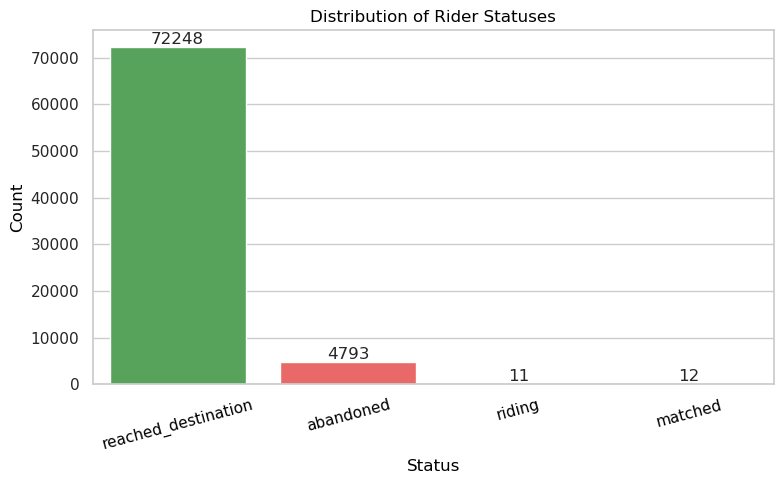

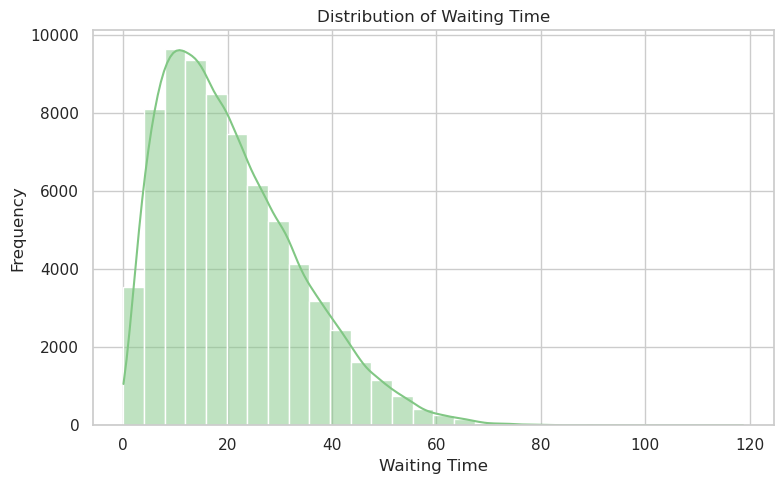

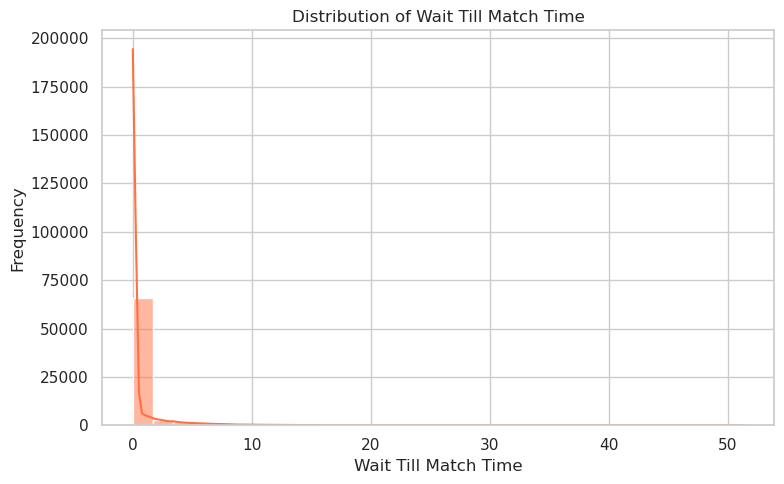

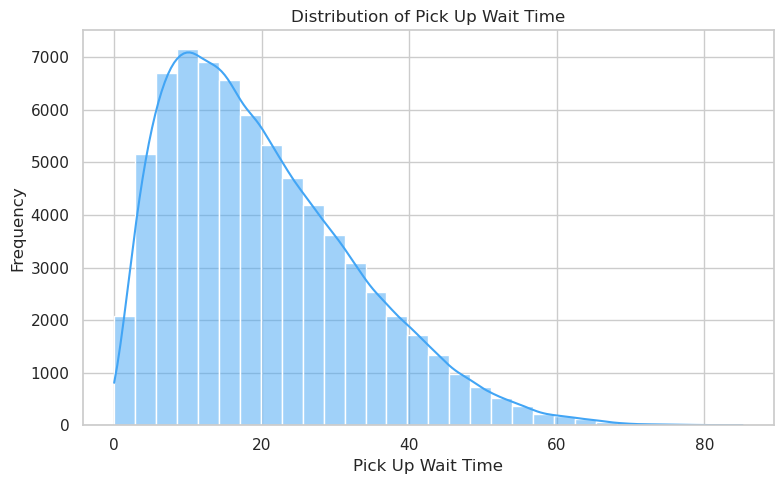

/tmp/ipykernel_56564/292679840.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])


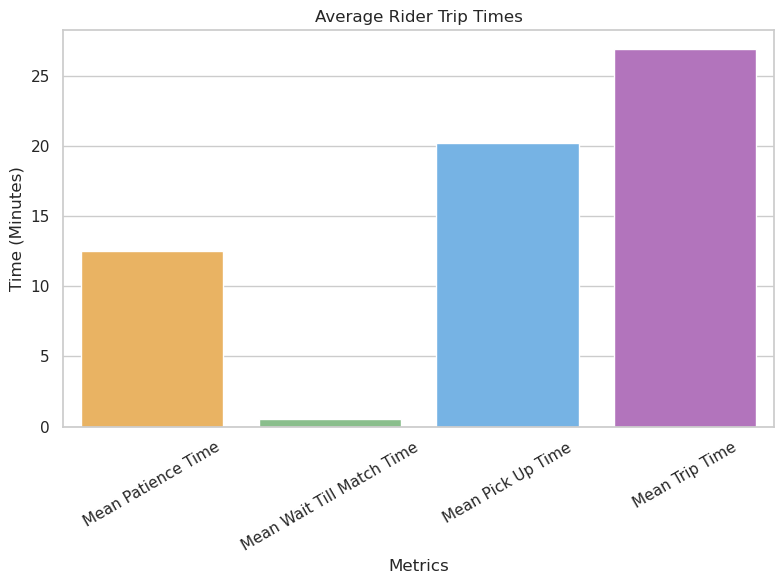

############# Rider statisfaction #######################
The system abandonment rate is 0.062 with a standard error of 0.001


/tmp/ipykernel_56564/1270590740.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)


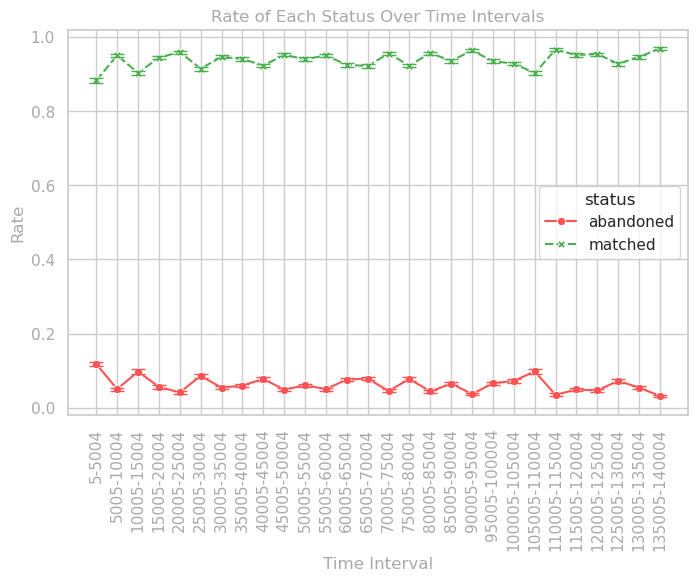

### wait Time ###
The system average riders wait time 20.773 with SE 0.048
### wait for match ###
The system wait until match time 0.550 with SE 0.007
### wait for pick up ###
The system wait for pick up time 20.223 with SE 0.047
----- Driver Earnings Analysis (Per Hour) -----
Average Earning per Hour: 0.349 with SE: 0.001
Average Fuel Cost per Hour: 0.052 with SE: 0.000
Average Profit per Hour: 0.297 with SE: 0.001
Gini Coefficient for Earnings per Hour: 0.115
SD Earnings per Hour: 0.07542


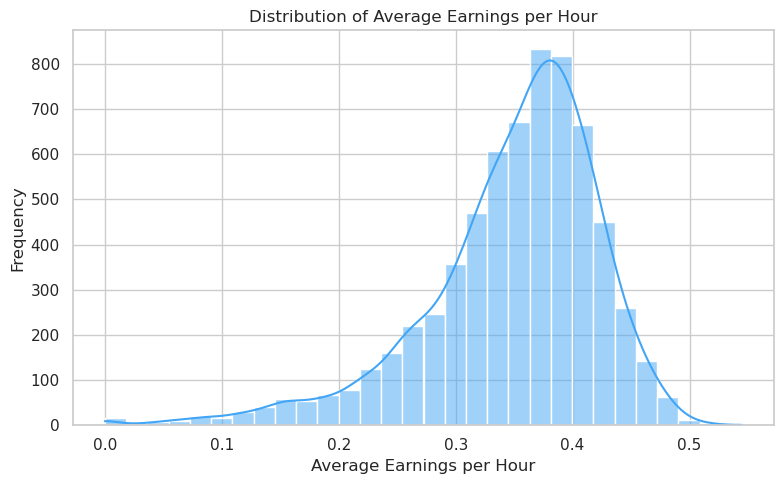

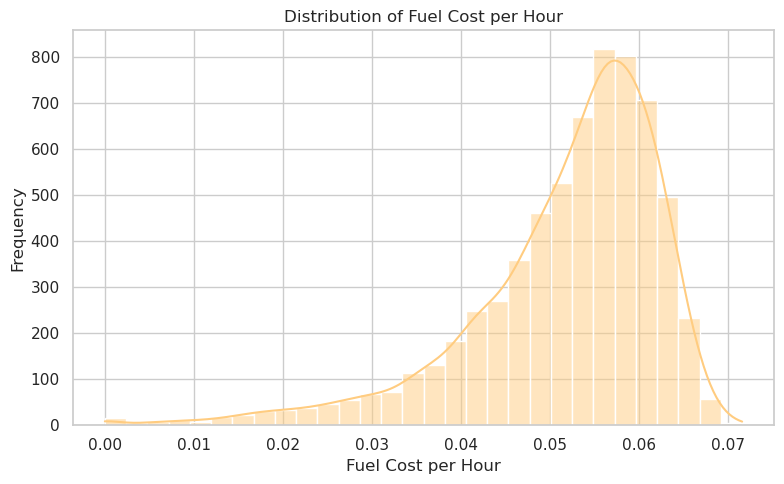

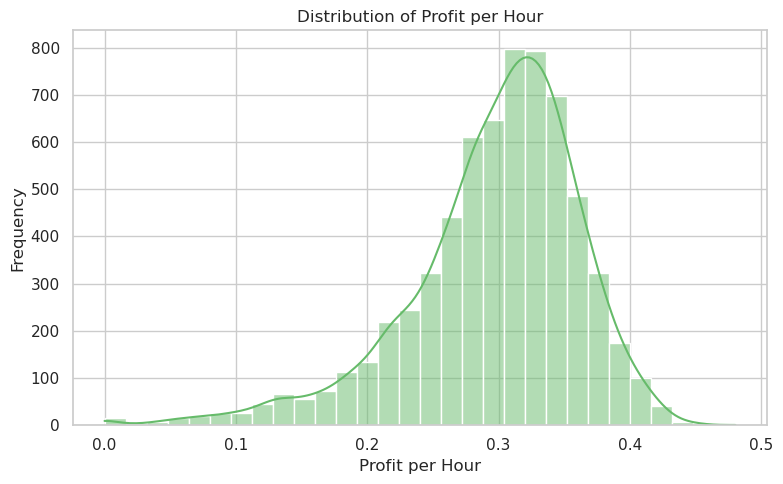

/tmp/ipykernel_56564/1937423374.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Earnings Component (per Hour)', y='Amount', data=melt_earnings, palette='Set2')


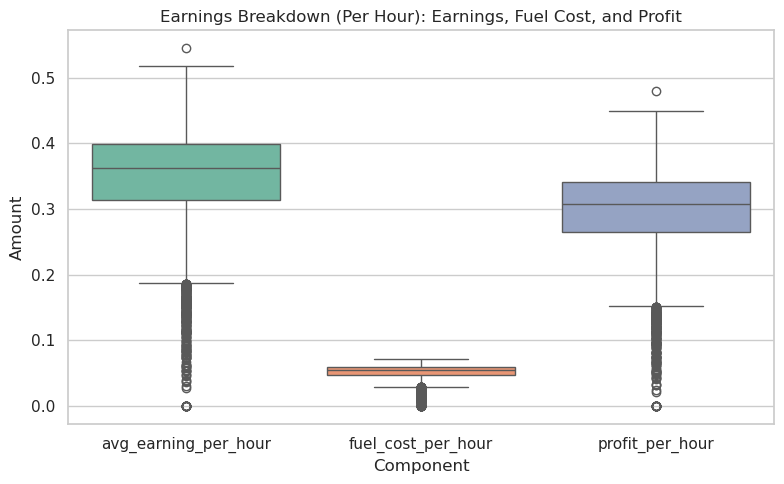

Time columns for breakdown: ['total_pickup_time', 'total_dropoff_time', 'total_idling_time']
Average total_pickup_time: 141.393 with SE: 0.494
Average total_dropoff_time: 193.249 with SE: 0.569
Average total_idling_time: 0.006 with SE: 0.004


/tmp/ipykernel_56564/1937423374.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time Category', y='Time', data=melt_time, palette='Set3')


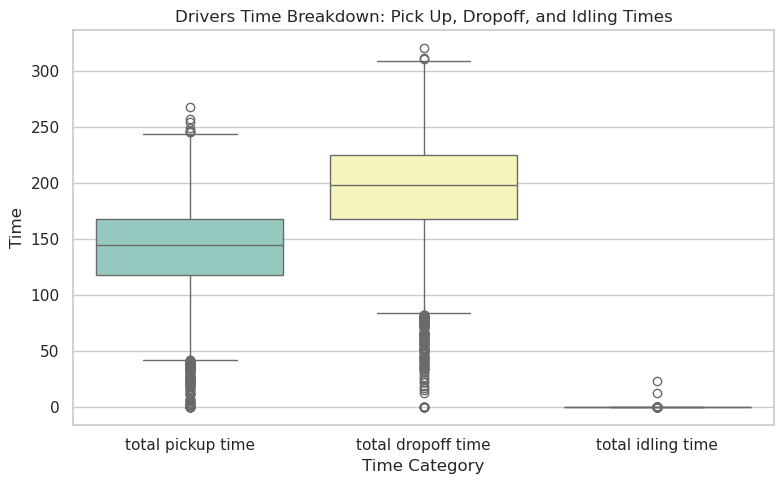

/tmp/ipykernel_56564/1937423374.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Distance Category', y='Distance', data=melt_distance, palette='Set2')


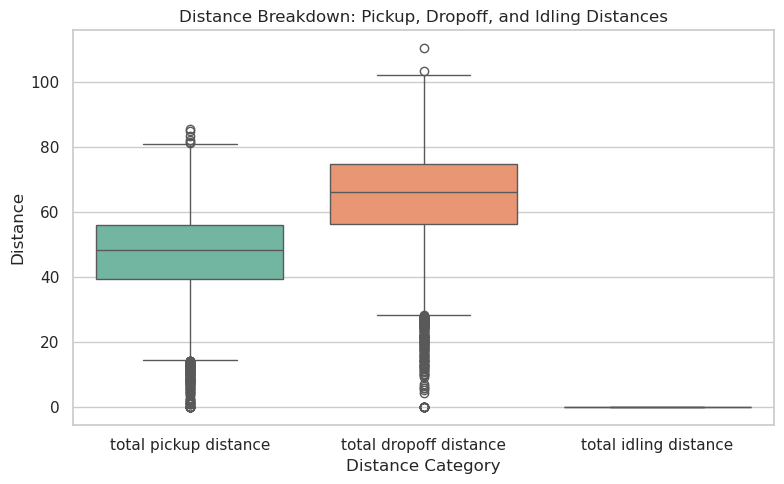

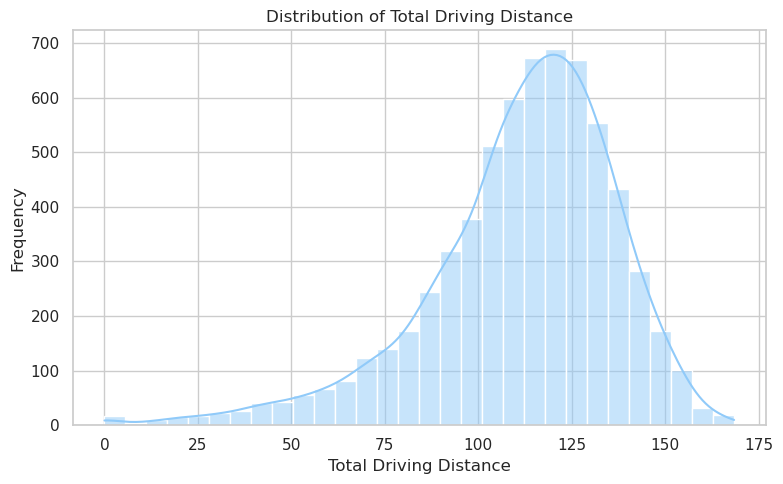

/tmp/ipykernel_56564/1937423374.py:225: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#90CAF9', '#FFA726', '#66BB6A'][:len(metrics)])


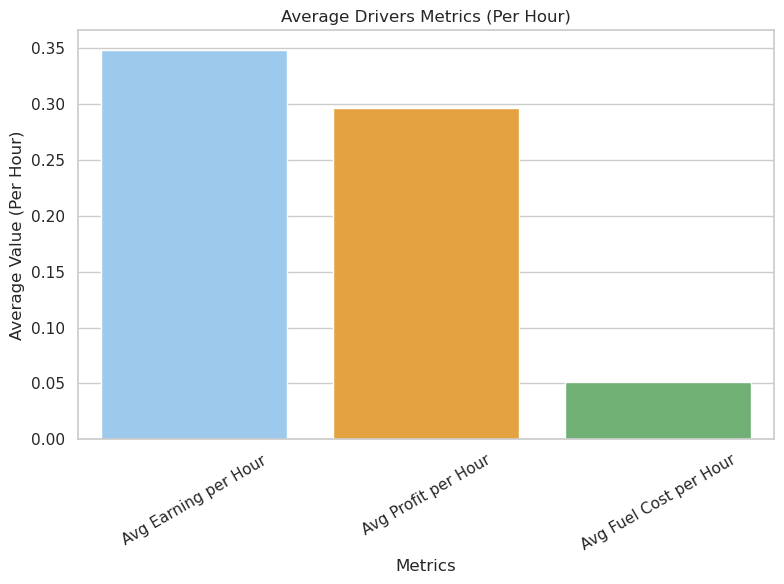

(            id                          current_location  \
 d_0        d_0   [10.699921402802193, 17.84944305086063]   
 d_1        d_1  [14.540620849582906, 5.8167720203537225]   
 d_2        d_2   [17.648107090487514, 16.39910045967901]   
 d_3        d_3  [1.6877455288710745, 2.6519338018599683]   
 d_4        d_4     [6.12453080674922, 4.066470141194162]   
 ...        ...                                       ...   
 d_9780  d_9780  [10.587877471304811, 17.106054653213913]   
 d_9781  d_9781      (9.2206543250837, 15.35018352840057)   
 d_9782  d_9782  (12.620048365155538, 14.282610336302277)   
 d_9783  d_9783  [14.876989998230561, 10.222566188129958]   
 d_9784  d_9784   [14.25842143595846, 13.241087705641492]   
 
                                           origin  become_available  \
 d_0       [16.66445752407555, 16.11091464448415]          6.901001   
 d_1     [11.541928114205248, 12.331502102691987]         11.982112   
 d_2      [6.780346346425538, 12.485571679216665]    

In [9]:
riders_analysis(riders_df)
drivers_analysis(drivers_df)

/tmp/ipykernel_56564/292679840.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')


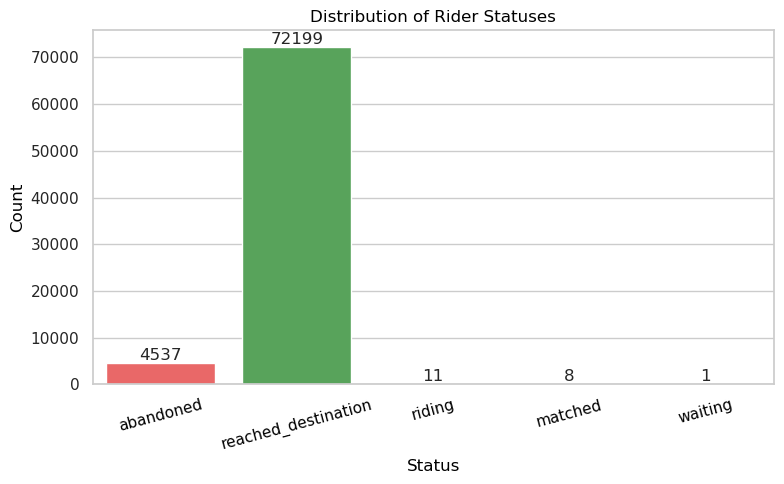

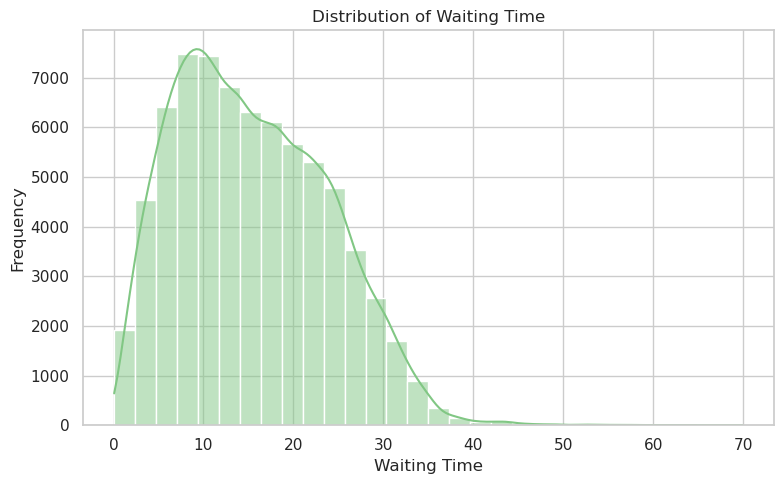

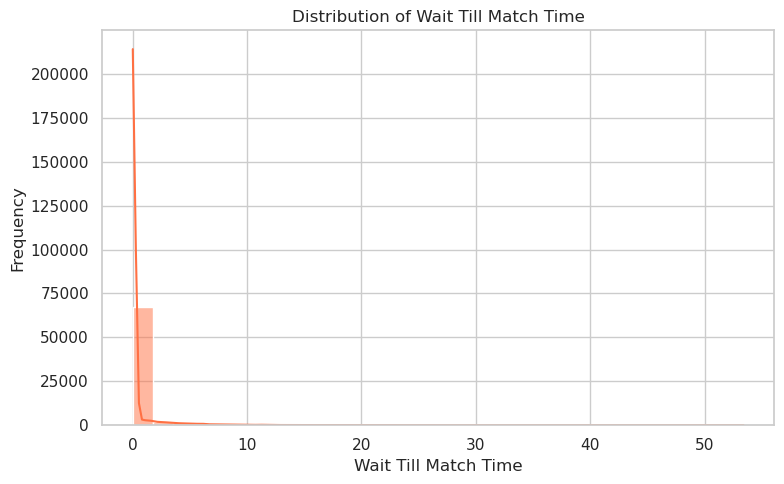

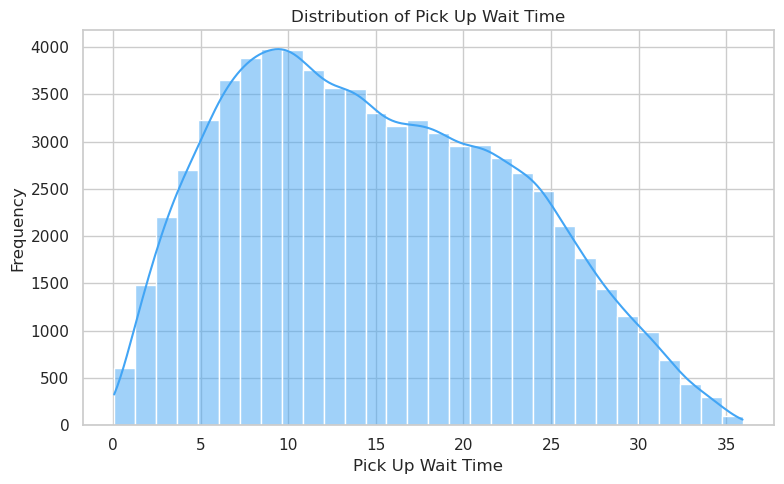

/tmp/ipykernel_56564/292679840.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])


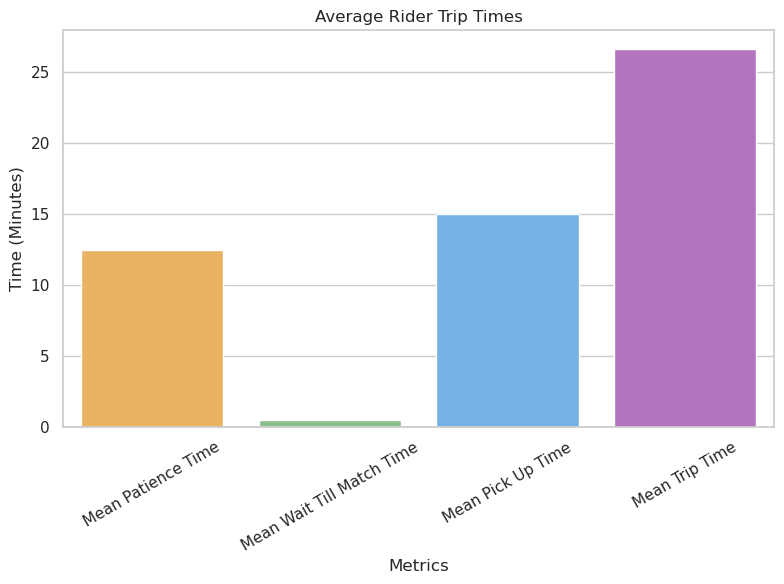

############# Rider statisfaction #######################
The system abandonment rate is 0.059 with a standard error of 0.001


/tmp/ipykernel_56564/1270590740.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)


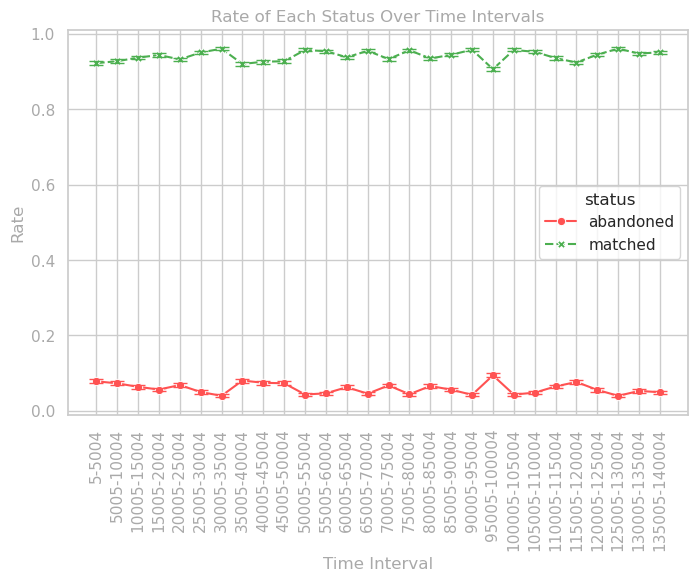

### wait Time ###
The system average riders wait time 15.477 with SE 0.031
### wait for match ###
The system wait until match time 0.460 with SE 0.007
### wait for pick up ###
The system wait for pick up time 15.017 with SE 0.030
----- Driver Earnings Analysis (Per Hour) -----
Average Earning per Hour: 0.374 with SE: 0.001
Average Fuel Cost per Hour: 0.058 with SE: 0.000
Average Profit per Hour: 0.317 with SE: 0.001
Gini Coefficient for Earnings per Hour: 0.104
SD Earnings per Hour: 0.07203


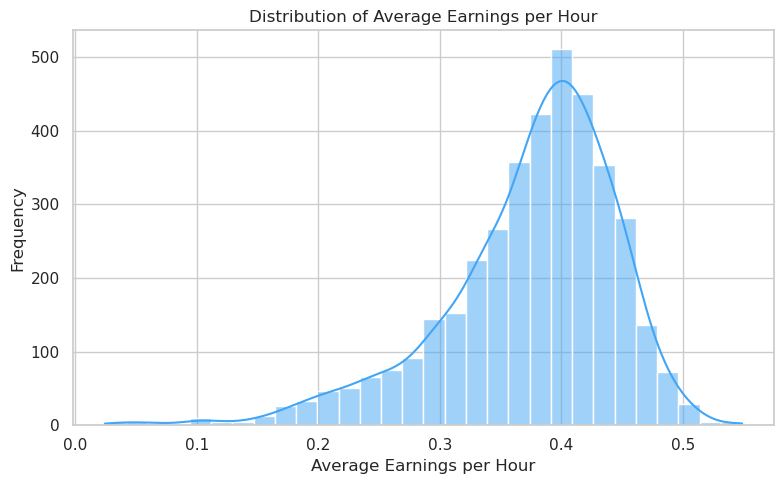

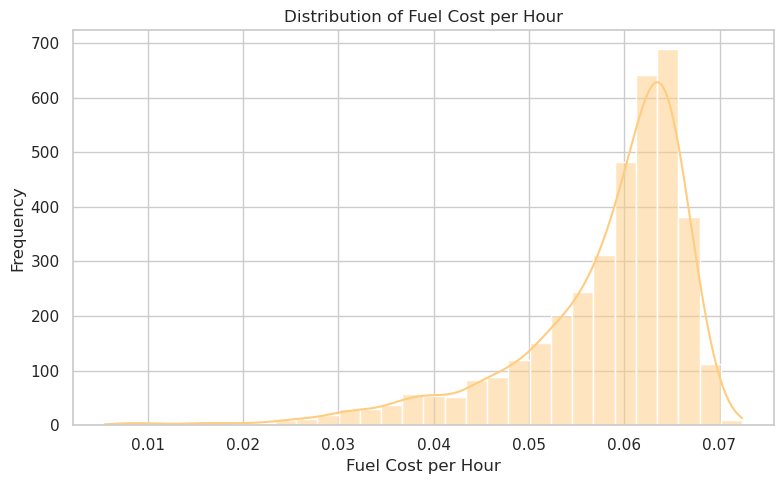

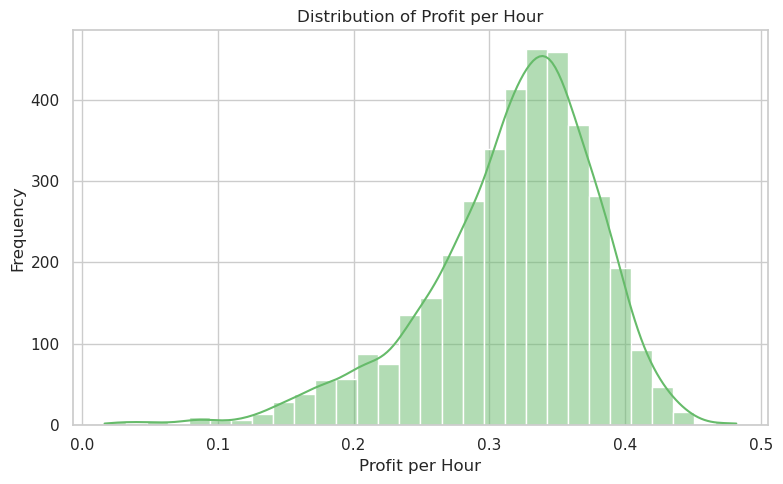

/tmp/ipykernel_56564/1937423374.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Earnings Component (per Hour)', y='Amount', data=melt_earnings, palette='Set2')


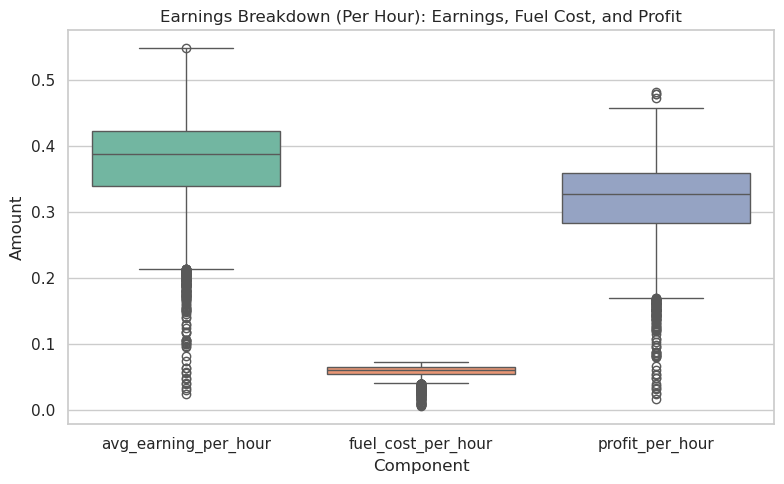

Time columns for breakdown: ['total_pickup_time', 'total_dropoff_time', 'total_waiting_point_travel_time', 'total_idling_time']
Average total_pickup_time: 116.451 with SE: 0.478
Average total_dropoff_time: 210.197 with SE: 0.733
Average total_waiting_point_travel_time: 52.159 with SE: 0.278
Average total_idling_time: 0.001 with SE: 0.001


/tmp/ipykernel_56564/1937423374.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time Category', y='Time', data=melt_time, palette='Set3')


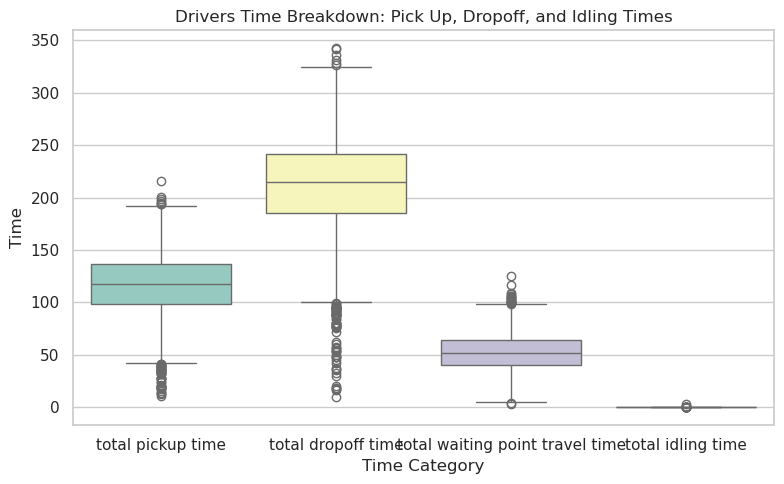

/tmp/ipykernel_56564/1937423374.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Distance Category', y='Distance', data=melt_distance, palette='Set2')


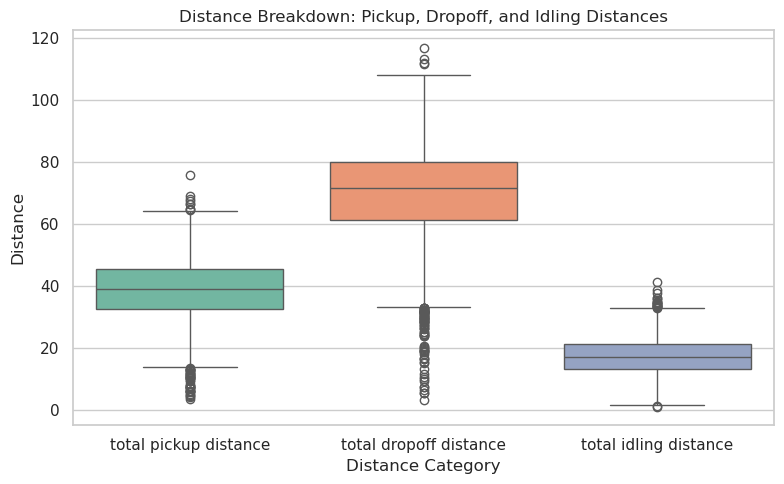

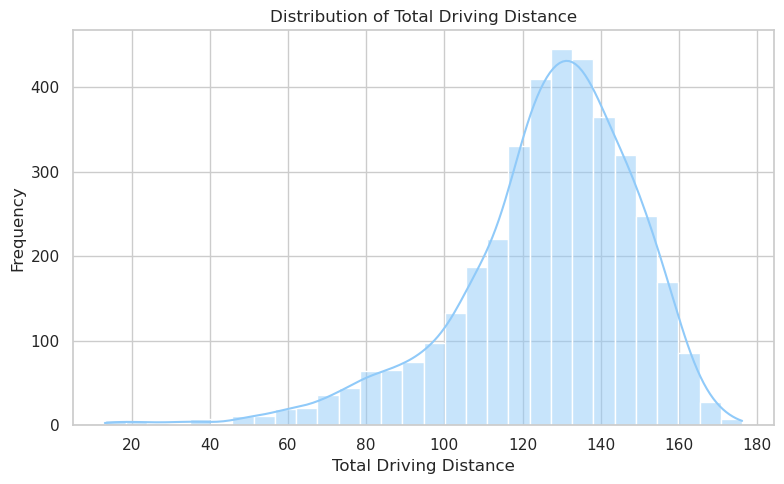

/tmp/ipykernel_56564/1937423374.py:225: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#90CAF9', '#FFA726', '#66BB6A'][:len(metrics)])


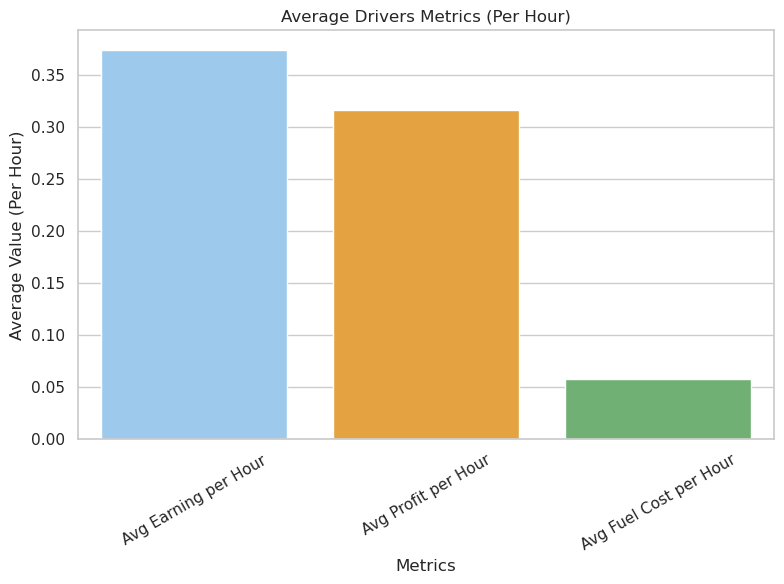

(            id                          current_location  \
 d_0        d_0    [7.903074035121547, 5.813482285799168]   
 d_1        d_1  [16.113971576896176, 15.921487006635907]   
 d_2        d_2   [17.987978708881553, 5.850642495938505]   
 d_3        d_3    [8.635879043812288, 13.45534292948395]   
 d_4        d_4   [15.582000698114184, 9.826227346028505]   
 ...        ...                                       ...   
 d_9675  d_9675   (9.800342950296258, 10.117047041194144)   
 d_9676  d_9676   (10.870704717950655, 6.241125664480747)   
 d_9677  d_9677   (5.042947906425235, 10.241302976856632)   
 d_9678  d_9678   (0.8614855876578371, 7.078909813525003)   
 d_9679  d_9679     (8.01404693433059, 10.19805046136388)   
 
                                           origin  become_available  \
 d_0       [16.66445752407555, 16.11091464448415]          6.901001   
 d_1     [11.541928114205248, 12.331502102691987]         11.982112   
 d_2       [9.59927496476681, 14.533403067208365]    

In [10]:
riders_analysis(improved_riders_df)
drivers_analysis(improved_drivers_df)

/tmp/ipykernel_3841/292679840.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')


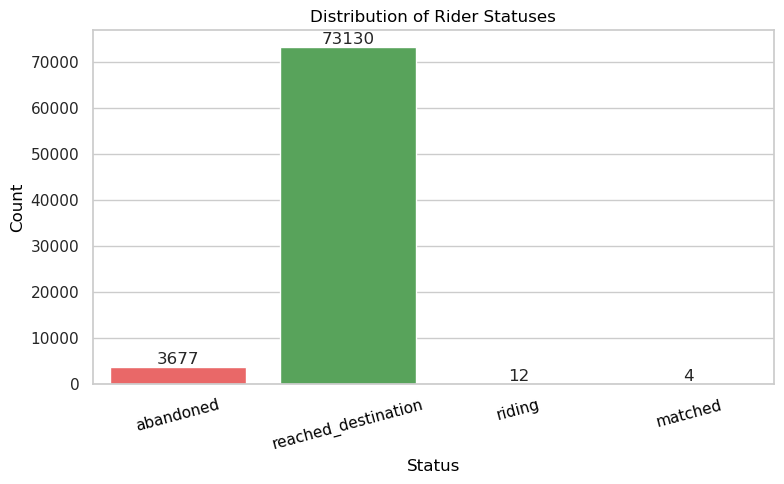

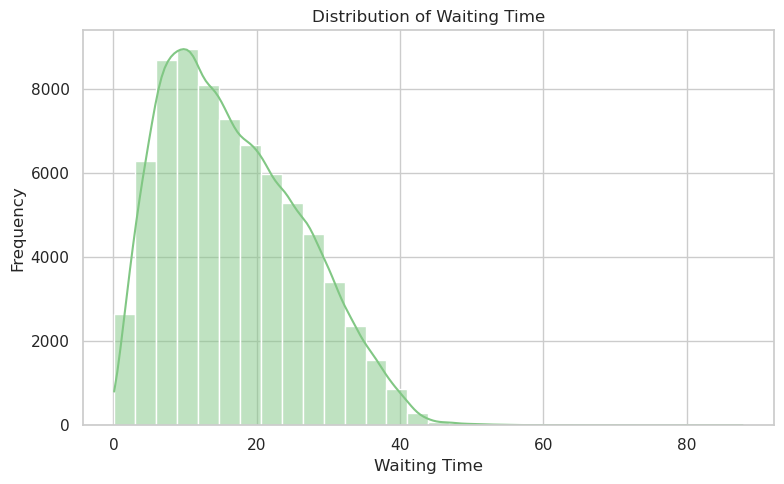

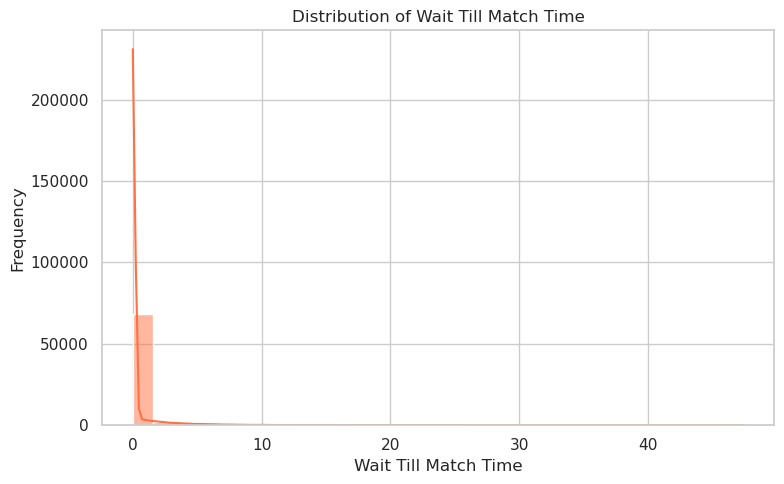

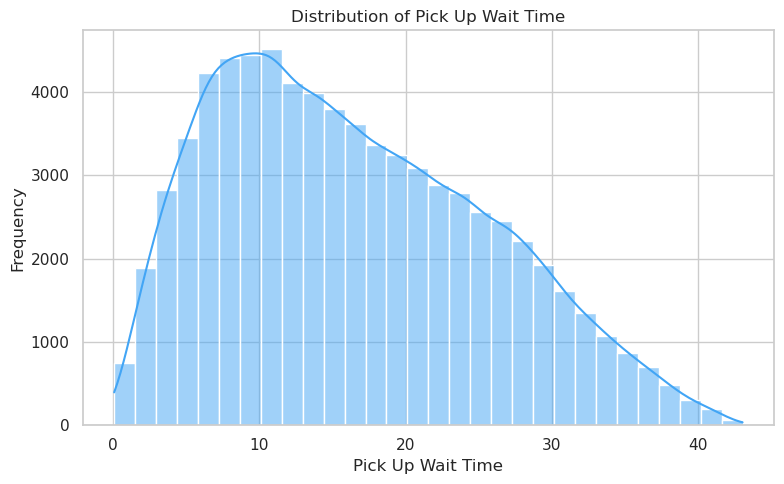

/tmp/ipykernel_3841/292679840.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])


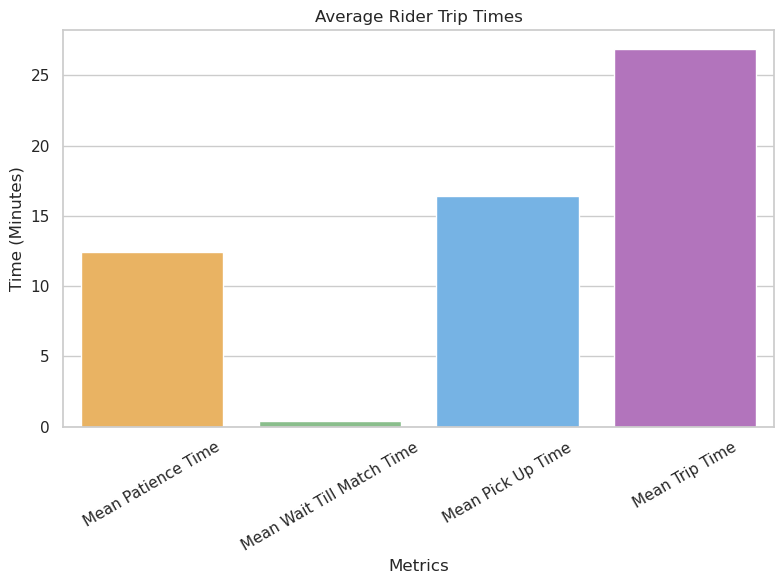

############# Rider statisfaction #######################
The system abandonment rate is 0.048 with a standard error of 0.001


/tmp/ipykernel_3841/1270590740.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)


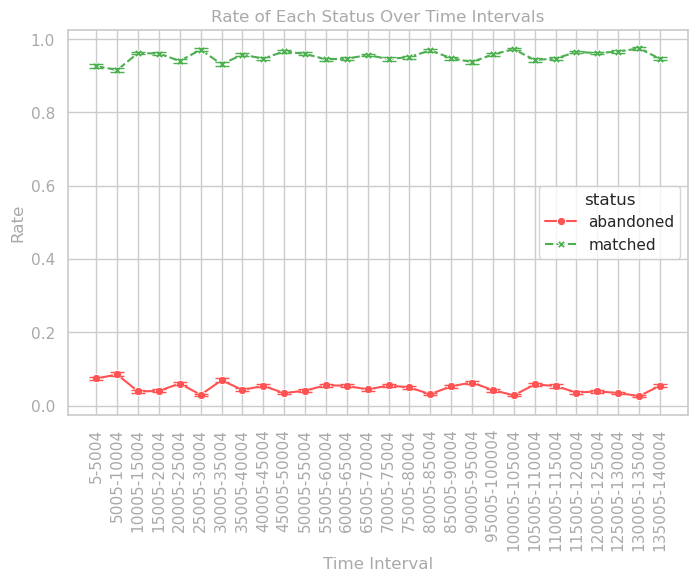

### wait Time ###
The system average riders wait time 16.808 with SE 0.035
### wait for match ###
The system wait until match time 0.394 with SE 0.006
### wait for pick up ###
The system wait for pick up time 16.413 with SE 0.034
----- Driver Earnings Analysis (Per Hour) -----
Average Earning per Hour: 0.358 with SE: 0.001
Average Fuel Cost per Hour: 0.056 with SE: 0.000
Average Profit per Hour: 0.301 with SE: 0.001
Gini Coefficient for Earnings per Hour: 0.103
SD Earnings per Hour: 0.06564


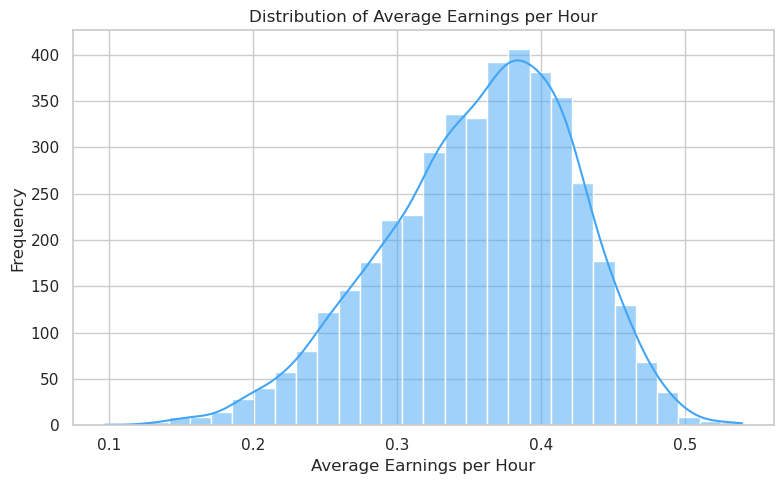

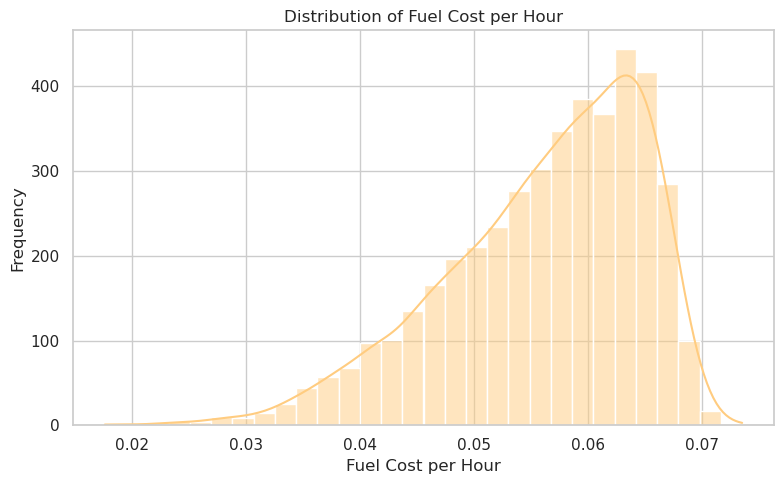

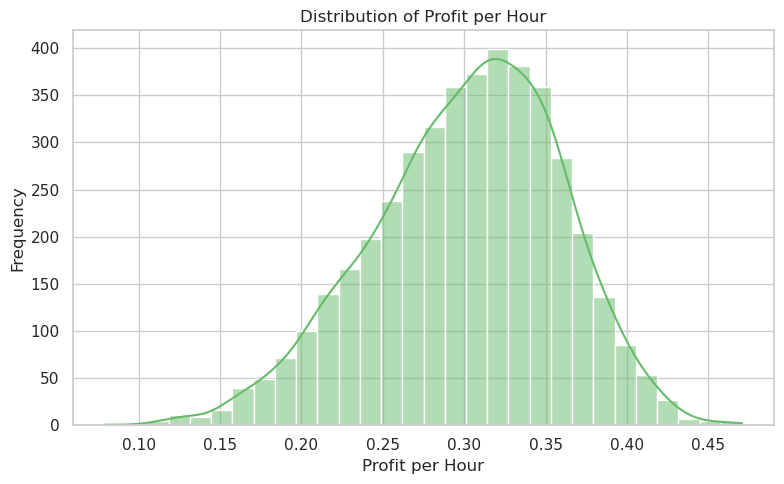

/tmp/ipykernel_3841/1937423374.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Earnings Component (per Hour)', y='Amount', data=melt_earnings, palette='Set2')


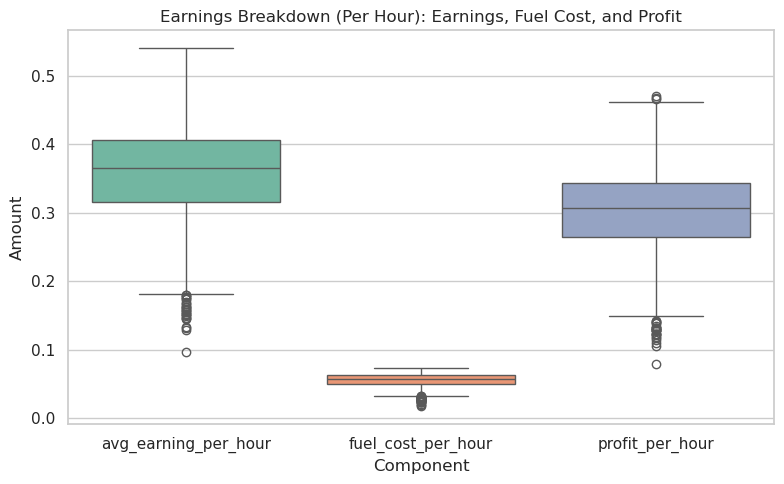

Time columns for breakdown: ['total_pickup_time', 'total_dropoff_time', 'total_waiting_point_travel_time', 'total_idling_time']
Average total_pickup_time: 121.243 with SE: 0.481
Average total_dropoff_time: 201.218 with SE: 0.632
Average total_waiting_point_travel_time: 45.328 with SE: 0.247
Average total_idling_time: 0.004 with SE: 0.004


/tmp/ipykernel_3841/1937423374.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time Category', y='Time', data=melt_time, palette='Set3')


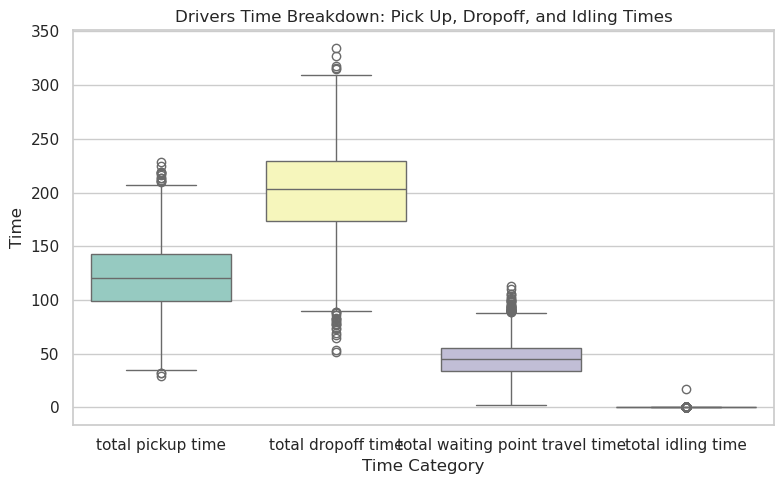

/tmp/ipykernel_3841/1937423374.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Distance Category', y='Distance', data=melt_distance, palette='Set2')


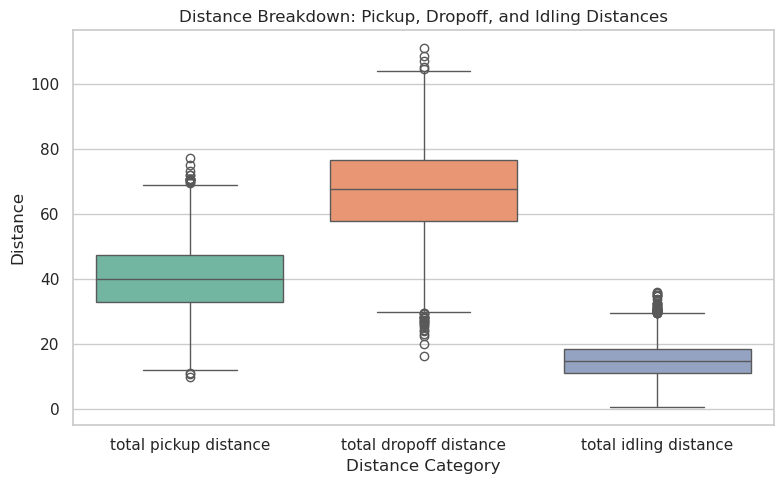

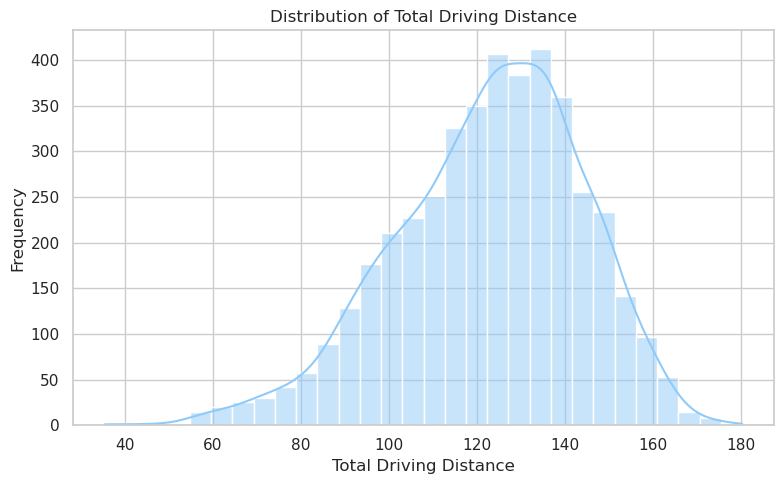

/tmp/ipykernel_3841/1937423374.py:225: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#90CAF9', '#FFA726', '#66BB6A'][:len(metrics)])


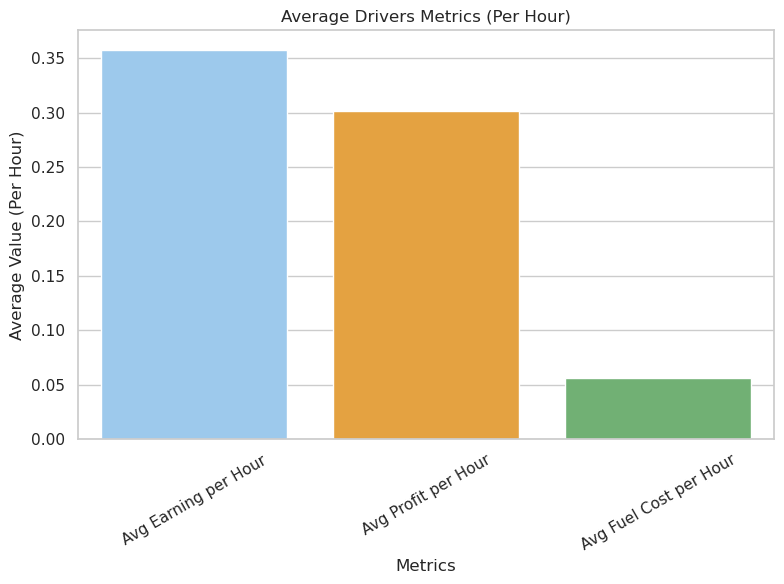

(            id                          current_location  \
 d_0        d_0   [10.223200803641387, 7.465659159901477]   
 d_1        d_1   [14.031847554933796, 8.542060411461211]   
 d_2        d_2   [12.434047476755186, 7.341259116567609]   
 d_3        d_3    [18.19966691365005, 12.65726749883603]   
 d_4        d_4  [11.905590447956577, 14.073042635600014]   
 ...        ...                                       ...   
 d_9730  d_9730   (15.249034321654422, 7.825089686063684)   
 d_9731  d_9731  (3.2097806173138395, 5.9080699504365235)   
 d_9732  d_9732   (8.082901511233255, 10.508241484442436)   
 d_9733  d_9733    (6.657733414758888, 2.347556115472336)   
 d_9734  d_9734   (10.960806000125126, 7.704039011622569)   
 
                                           origin  become_available  \
 d_0       [16.66445752407555, 16.11091464448415]          6.901001   
 d_1     [11.541928114205248, 12.331502102691987]         11.982112   
 d_2       [9.59927496476681, 14.533403067208365]    

In [16]:
riders_analysis(improved_riders_df)
drivers_analysis(improved_drivers_df)